In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.chdir("../..")


In [3]:
import numpy as np
import json

from enum import Enum

from typing import Callable
from numpy.typing import NDArray

from qiskit import QuantumCircuit
from qiskit.circuit.gate import Gate as QkGate
from qiskit.circuit import Parameter, Instruction


In [4]:
from qml.model.gate import Gateset, Gate, GateInfo
from qml.tools.random import XRandomGenerator
from qml.tools.typing import Vector, IntVector


In [42]:
class Unit:
    
    VALUE_MAX = 2 * np.pi

    def __init__(
            self,
            name: str,
            gates: list[Gate],
            params: list[Parameter],
            values: Vector,
    ):
        self._name = name
        self._gates = gates
        self._params = params
        self._values = self.format(values)

    def feed_dict(self, values=None) -> dict[str, float]:
        if values is None:
            values = self.values
        if not hasattr(values, "__len__"):
            values = [values]
        assert len(values) == len(
            self.parameters), f"Length of values {len(values)} must be equal to number of parameters {len(self.values)}"

        feed_dict = dict()
        for param, value in zip(self._params, values):
            feed_dict |= {
                param.name: value
            }
        return feed_dict

    def apply_to_qc(self, qc: QuantumCircuit) -> QuantumCircuit:
        for gate in self._gates:
            gate.apply_to_qc(qc)
        return qc

    @classmethod
    def format(cls, values: Vector) -> NDArray:
        values = np.asarray(values)
        if values.ndim == 0:
            values = values[np.newaxis]
        return values % cls.VALUE_MAX

    def apply_to_qc(self, qc: QuantumCircuit) -> QuantumCircuit:
        for gate in self._gates:
            gate.apply_to_qc(qc)
        return qc

    @property
    def values(self):
        return self._values.copy()

    @values.setter
    def values(self, values):
        assert len(values) == len(
            self.values), f"Length of values {len(values)} must be equal to number of parameters {len(self.values)}"
        values = np.asarray(values)
        values = values % self.VALUE_MAX
        self._values = values

    @property
    def parameters(self):
        return self.values

    @parameters.setter
    def parameters(self, values):
        self.values = values

    @property
    def gates(self):
        return [gate for gate in self._gates]

    @property
    def parameter_instances(self):
        return self._params

    @property
    def num_param(self):
        return len(self._params)
    
    def to_string(self):
        ret = self._name + "|"
        ret += ",".join([g.gate.name for g in self.gates])
        ret += "/"
        ret += ",".join([str(g.qubit) for g in self.gates])
        ret += "/"
        ret += ",".join([f"{p:5.3f}" for p in self.parameters])
        return ret
    
    def to_json(self):
        data = dict(
            name=self._name,
            gates=[g.gate.name for g in self.gates],
            qubits=[int(g.qubit) for g in self.gates],
            params=[np.floor(p).item() for p in self.parameters]
        )
        str_data = json.dumps(data)
        return str_data



In [43]:
gset = Gateset.set_num_qubits(2)
infos = [gset.RX]
params = [Parameter("dev")]
values = np.zeros_like(params)
gates = [Gate.new_with_info(info, 0, param) for info, param in zip(infos, params)]

unit = Unit("dev", gates, params, values)
unit.to_json()


'{"name": "dev", "gates": ["rx"], "qubits": [0], "params": [0.0]}'

In [47]:
class UnitManager:

    def __init__(
            self,
            num_qubits: int,
            num_gates: int,
            seed: int = None,
    ):
        self._rng = XRandomGenerator(seed=seed)
        self._nq = num_qubits
        self._ng = num_gates

        self.gset = Gateset.set_num_qubits(num_qubits)

        self.num_generated = 0
    
    def generate_random_unit(
            self,
            num_gate: int = None,
            gateset: dict[str, GateInfo] = None,
            name: str = None,
            random_values: bool = False,
    ) -> Unit:
        if gateset is None:
            gateset = Gateset.set_num_qubits(self._nq, seed=self._rng.new_seed())
        ng = num_gate if num_gate is not None else self._ng
        
        # select gate at random
        infos = [gateset.get_at_random() for _ in range(ng)]
        qubits = self._rng.integers(0, self._nq, size=ng)
        return self.new_with_info_and_qubits(infos, qubits, name=name, random_values=random_values)

    def new_with_info_and_qubits(self, infos: list[GateInfo], qubits: IntVector, name: str = None, random_values: bool = False, use_name_direct: bool = False) -> Unit:
        if name is None:
            name = "unit"
        if not use_name_direct:
            name = name + f"_{self.num_generated}"

        gates = []
        params = []

        for info, qubit in zip(infos, qubits):
            if not info.trainable:
                gates.append(Gate.new_with_info(info, qubit))
                continue

            pname = f"param_{len(params)}"
            pname = "_".join([name, pname])
            param = Parameter(pname)
            params.append(param)
            gates.append(Gate.new_with_info(info, qubit, param))

        values = np.zeros_like(params) if not random_values else self._rng.uniform(low=0, high=self.VALUE_MAX, size=len(params))
        self.num_generated += 1

        return Unit(name, gates, params, values)

    def from_string(self, genome: str):
        uname, strunit_vals = genome.split("|")
        gnames, qubits, params = [
            strunit_part.split(",")
            for strunit_part in strunit_vals.split("/")
        ]
        infos = [self.gset.get(gname) for gname in gnames]
        qubits = [int(qubit) for qubit in qubits]
        params = np.asarray([float(param) for param in params])

        unit = self.new_with_info_and_qubits(infos, qubits, uname, use_name_direct=True)
        unit.parameters = params
        return unit
    
    def from_json(self, genome: str):
        data = json.loads(genome)
        infos = [self.gset.get(gname) for gname in data["gates"]]
        qubits = [int(qubit) for qubit in data["qubits"]]
        params = np.asarray([float(param) for param in data["params"]])
        unit = self.new_with_info_and_qubits(infos, qubits, data["name"], use_name_direct=True)
        unit.parameters = params
        return unit


uman = UnitManager(3, 3)
unit = uman.generate_random_unit()
strunit = unit.to_json()
print(strunit)
strunit_rev = uman.from_json(strunit)
print(strunit_rev.to_json())


{"name": "unit_0", "gates": ["ry", "rz", "rx"], "qubits": [0, 1, 2], "params": [0.0, 0.0, 0.0]}
{"name": "unit_0", "gates": ["ry", "rz", "rx"], "qubits": [0, 1, 2], "params": [0.0, 0.0, 0.0]}


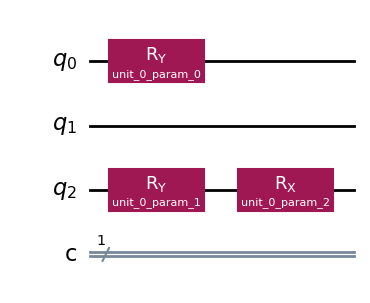

In [37]:
qc = QuantumCircuit(3, 1)
qc = unit.apply_to_qc(qc)
qc.draw("mpl")
